In [23]:
%matplotlib inline
from nilearn import plotting as niplt
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mplcolors
import joblib
import itertools
import glob
import nibabel as nib
import matplotlib as ml
from random import shuffle
import os
%load_ext autoreload
%autoreload 1
%aimport base.plotting
%aimport base.img_tools
# %aimport base.img_plot 

# import fastcluster
from scipy.cluster.hierarchy import fcluster, dendrogram, cophenet
from neurosynth.analysis.cluster import Clusterable

from base.tools import mask_diagonal
from sklearn.metrics import pairwise_distances

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from base.classifiers import OnevsallClassifier
from neurosynth.base.dataset import Dataset
dataset = Dataset.load("../data/0.6/datasets/db_v6_topics-60.pkl")

In [4]:
sns.set_context('talk')
sns.set_style('ticks')

# Full hierarchical, selecting frontal regions

## Select LFC regions

In [5]:
wb_Z = joblib.load('../results/clustering/hierarchical/v6_ward_c30_scaled.pkl')
LFC_mask = nib.load('../masks/LFC_MNI_noMedialOFC_FOC.nii.gz')
LFC_mask_1p = nib.load('../masks/LFC_MNI_noMedialOFC_FOC_1p.nii.gz')
LFC_masker = Clusterable(dataset, LFC_mask, min_studies=100).masker
whole_brain_clusterable = Clusterable(dataset, '../masks/HO_ROIs/cortex_30.nii.gz', min_studies=100)
whole_brain_masker = whole_brain_clusterable.masker

/Users/alejandro/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: The file '../results/clustering/hierarchical/v6_ward_c30_scaled.pkl' has been generated with a joblib version less than 0.10. Please regenerate this pickle file.
  if __name__ == '__main__':


In [ ]:
all_silhouettes = pd.concat([pd.read_csv('../results/clustering/hierarchical/v6_ward_c30_scaled_LFC_sils.csv'), 
           pd.read_csv('../results/clustering/hierarchical/v6_ward_c30_scaled_LFC_sils_40_120.csv')])[['n_clusters', 'silhouette_score']]

In [6]:
all_silhouettes = all_silhouettes[all_silhouettes.silhouette_score.shift() != all_silhouettes.silhouette_score]

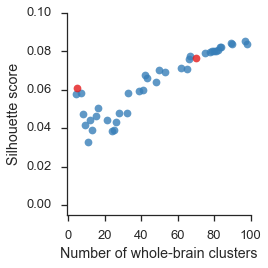

In [8]:
all_silhouettes['selected'] = all_silhouettes.n_clusters.isin([5, 70]).astype('int')
p = sns.lmplot('n_clusters', 'silhouette_score', hue='selected', data=all_silhouettes[(all_silhouettes.n_clusters < 101) & (all_silhouettes.n_clusters > 3)], fit_reg=False, 
              scatter_kws={"s": 60}, palette = reversed(sns.color_palette('Set1', 2)), legend=False, size=4, aspect=1)
p.set_xlabels('Number of whole-brain clusters')
p.set_ylabels('Silhouette score')
p.ax.set_ylim(-.005, 0.1)
p.ax.set_xlim(-1, 100)
plt.savefig('../reports/dissertation/figures/silhouettes.png')

### Calculate number of voxels in mask

In [11]:
from sklearn.metrics import adjusted_rand_score

In [12]:
n_in_mask = 0
perc = []
perc_in_mask = []
percentage = .5
masked_labels = []
for i, n_reg in enumerate(range(20, 100)):
    last_labels = masked_labels
    labels = fcluster(wb_Z, n_reg, 'maxclust')
    wb_cluster = nib.Nifti1Image(whole_brain_masker.unmask(labels), affine=LFC_mask.get_affine())
    
    in_mask, masked_clustering = base.img_tools.mask_clusters(wb_cluster, LFC_mask, amount=percentage)
    n_in_mask = np.unique(masked_clustering.get_data()).shape[0] - 1
    
    masked_labels = labels[whole_brain_masker.mask(LFC_mask.get_data()) == 1]
    
    masked_data = masked_clustering.get_data().copy()
    masked_data[LFC_mask_1p.get_data() == 1] = 0
    masked_data[masked_data > 0] = 1
    
    if (i > 0) and (adjusted_rand_score(masked_labels, last_labels) < 1):
        perc.append([n_reg, n_in_mask,
                            LFC_masker.mask(masked_clustering).astype('bool').mean(),
                    whole_brain_masker.mask(masked_data).mean()])        
#         nib.save(masked_clustering, '../results/clustering/hierarchical/fastward_v6_scaled_LFC/flat_k%d_o%d_%dp' % (n_in_mask, n_reg, percentage*100))

KeyboardInterrupt: 

In [747]:
perc_select = []
for n_reg, percentage in [(7, 0.1), (33, 0.3), (70, .5)]:
    labels = fcluster(wb_Z, n_reg, 'maxclust')
    wb_cluster = nib.Nifti1Image(whole_brain_masker.unmask(labels), affine=LFC_mask.get_affine())
    
    in_mask, masked_clustering = base.img_tools.mask_clusters(wb_cluster, LFC_mask, amount=percentage)
    n_in_mask = np.unique(masked_clustering.get_data()).shape[0] - 1
    
    masked_labels = labels[whole_brain_masker.mask(LFC_mask.get_data()) == 1]
    
    masked_data = masked_clustering.get_data().copy()
    masked_data[LFC_mask_1p.get_data() == 1] = 0
    masked_data[masked_data > 0] = 1
    perc_select.append([n_reg, n_in_mask, percentage,
                    LFC_masker.mask(masked_clustering).astype('bool').mean(),
            whole_brain_masker.mask(masked_data).mean()])        

In [748]:
perc_select = pd.DataFrame(perc_select, columns=['n_clusters', 'n_lfc', 'threshold', 'perc_in_mask', 'perc_out_mask'])

In [749]:
perc_select

n_clusters  n_lfc  threshold  perc_in_mask  perc_out_mask
0           7      5        0.1      0.980402       0.485564
1          33     10        0.3      0.862855       0.096682
2          70     16        0.5      0.862855       0.007627

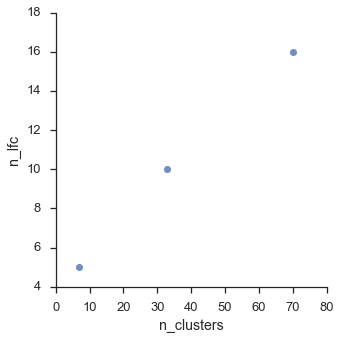

In [763]:
sns.lmplot('n_clusters', 'n_lfc', data=perc_select, fit_reg=False, scatter_kws={"s": 50})

####  % of voxels in mask in selected clusters

(-1, 35)

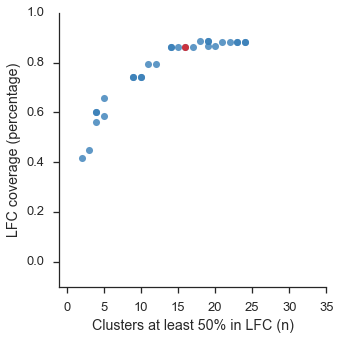

In [696]:
perc['Local maxima'] = perc.n_clusters.isin([70])
p = sns.lmplot('n_lfc', 'perc_in_mask', hue='Local maxima', data=perc, fit_reg=False,
              scatter_kws={"s": 50}, palette = reversed(sns.color_palette('Set1', 2)), legend=False)
p.ax.set_xlabel('Clusters at least 50% in LFC (n)')
p.ax.set_ylabel('LFC coverage (percentage)')
p.ax.set_ylim(-.1, 1)
p.ax.set_xlim(-1, 35)

(-1, 35)

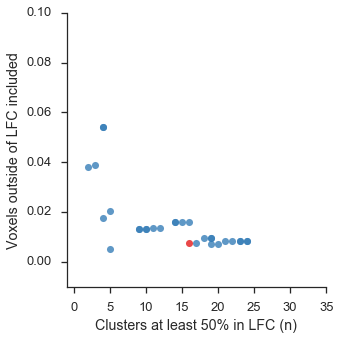

In [697]:
p = sns.lmplot('n_lfc', 'perc_out_mask', hue='Local maxima', data=perc, fit_reg=False, 
              scatter_kws={"s": 50}, palette = reversed(sns.color_palette('Set1', 2)), legend=False)
p.ax.set_xlabel('Clusters at least 50% in LFC (n)')
p.ax.set_ylabel('Voxels outside of LFC included')
p.ax.set_ylim(-.01, .1)
p.ax.set_xlim(-1, 35)

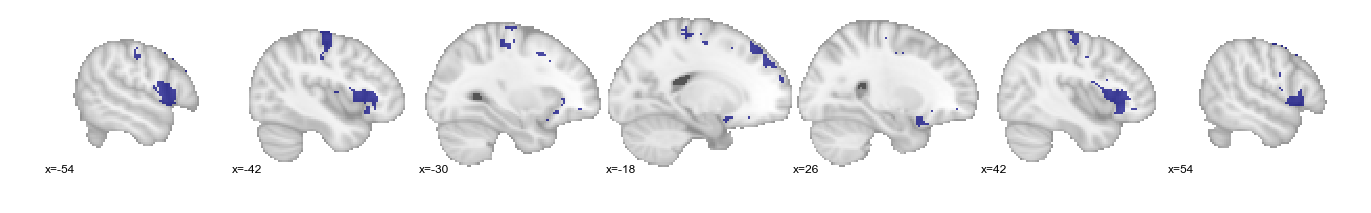

In [226]:
labels = fcluster(wb_Z, 70, 'maxclust')
wb_cluster = nib.Nifti1Image(whole_brain_masker.unmask(labels), affine=LFC_mask.get_affine())

in_mask, masked_clustering = base.img_tools.mask_clusters(wb_cluster, LFC_mask, amount=.5)

vox_excluded = nib.Nifti1Image(LFC_masker.unmask(LFC_masker.mask(masked_clustering).astype('bool') == False), 
                               LFC_mask.get_affine())
niplt.plot_roi(vox_excluded, display_mode='x')

In [227]:
nib.save(vox_excluded, '../results/clustering/hierarchical/fastward_v6_scaled_LFC/vox_excluded_LFC_k70.nii.gz')

In [228]:
voxels_clustered = masked_clustering.get_data().copy().astype('bool')
voxels_clustered[LFC_mask.get_data() == 1] = 0
voxels_clustered = voxels_clustered.astype('float32')

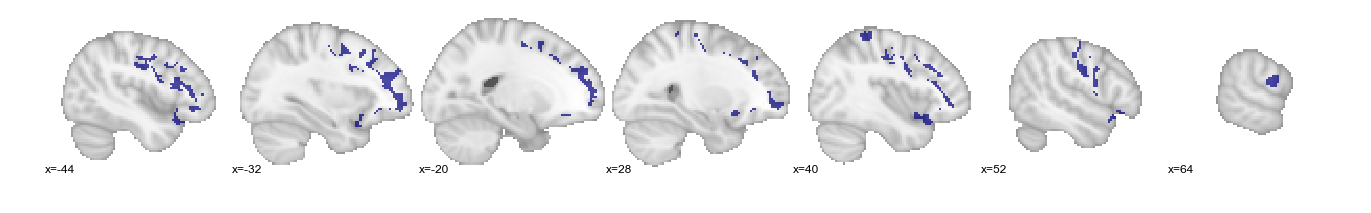

In [229]:
vox_not_LFC = nib.Nifti1Image(voxels_clustered, 
                               LFC_mask.get_affine())
niplt.plot_roi(vox_not_LFC, display_mode='x')

In [230]:
nib.save(vox_not_LFC, '../results/clustering/hierarchical/fastward_v6_scaled_LFC/vox_not_LFC_k26_40.nii.gz')

Goal - Identify 'networks' in LFC and two solutions at two levels of granularity

Network: range 6-16 networks, are by definition distributed, we elected to select only 20% coverage '
Coarse LFC solution: selected inital solution with jump in silhouette score. As many clusters continued to include non LFC voxels, we sought to include clusters with at least 33% of voxels in LFC. This threshold resulted in high LFC coverage with relatively few voxels outside primarily in parietalcortexd
Fine-grained solution: selected solution that had high coverage of LFC (90%) and very low coverage outside

## Try clustering in R

In [31]:
%load_ext rpy2.ipython

In [10]:
%%R
library(dendextend)
clust <- readRDS('../results/clustering/hierarchical/Rclust_wb.R')
dend <- as.dendrogram(clust)

/Users/aleph4/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
---------------------
Welcome to dendextend version 1.2.0
Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
Or contact: <tal.galili@gmail.com>

	To suppress this message use:  suppressPackageStartupMessages(library(dendextend))
---------------------


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/aleph4/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dendextend’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/Users/aleph4/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following object is masked from ‘package:stats’:

    cutree


  res = super(Function, self).__call__(*new_args, 

In [6]:
import tempfile
import random
from copy import deepcopy
from base.tools import map_clusters
from matplotlib.colors import rgb2hex

In [7]:
k_5 = nib.Nifti1Image(whole_brain_masker.unmask(fcluster(wb_Z, 5, 'maxclust')), affine=LFC_mask.get_affine())
_, l_5 = base.img_tools.mask_clusters(k_5, LFC_mask, amount=.1)
k_33 = nib.Nifti1Image(whole_brain_masker.unmask(fcluster(wb_Z, 33, 'maxclust')), affine=LFC_mask.get_affine())
_, l_33 = base.img_tools.mask_clusters(k_33, LFC_mask, amount=.25)
k_70 = nib.Nifti1Image(whole_brain_masker.unmask(fcluster(wb_Z, 70, 'maxclust')), affine=LFC_mask.get_affine())
_, l_70 = base.img_tools.mask_clusters(k_70, LFC_mask, amount=.75)

In [8]:
nib.save(l_70, 'test51.nii.gz')

In [9]:
l_5_colors_hex = [rgb2hex(col) for col in l_5_colors]
l_70_colors_hex = [rgb2hex(col) for col in l_70_colors]

NameError: name 'l_5_colors' is not defined

In [255]:
dendogram_nums = [0] * 70

In [260]:
dendrogram_colors_70 = []
i = 0
for p, v in enumerate(dendogram_nums):
    if p in l_70to5_origi.keys():
        dendrogram_colors_70.append(l_70_colors_hex[i])
        i += 1
    else:
        dendrogram_colors_70.append("white")

In [259]:
l_70_orig_labels = np.unique(base.img_tools.mask_clusters(k_70, LFC_mask, amount=.5, compress=False)[1].get_data())[1:]

l_5to_orig70 = {l_5_colors_hex[1]: [34, 36], l_5_colors_hex[2]: [37,  38,  39,  40,  41,  42,  43,  50,
        52], l_5_colors_hex[3]: [56,  62,  69]}
l_70to5_origi = {i-1:k for k, v in l_5to_orig70.items() for i in v }

In [261]:
dendrogram_colors_5 = [l_70to5_origi[p] if p in l_70to5_origi.keys() else "grey" for p, v in enumerate(dendogram_nums)]
dendrogram_prune = [p+1 for p, v in enumerate(dendogram_nums) if p not in l_70to5_origi.keys()]
%Rpush dendrogram_colors_5
%Rpush dendrogram_colors_70

%Rpush dendrogram_prune

In [276]:
%Rpush l_5_colors_hex
%Rpush l_70_colors_hex

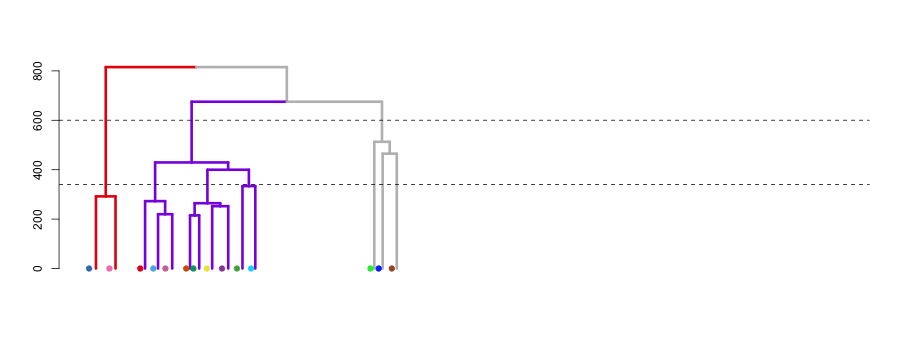

In [361]:
%%R -w 900 -h 350
# png(filename='../reports/lfc/figures/pruned_k70_dendrogram.png', 900, 350)

k_70_dend <- cut(dend, h=209)$upper
k_70_dend  %>% 
set("labels", c(1:71)) %>%
set("branches_col", c('grey')) %>%
set("branches_k_color", value = c("grey", l_5_colors_hex), k = 5) %>% 
# set("branches_k_color", value = c(1, 2, 3), k = 33) %>% 
prune(dendrogram_prune) %>% 
set("branches_lwd", 3.5) %>%
hang.dendrogram(-1) %>%
set("leaves_pch", 19) %>%
set("leaves_cex", 1) %>%
set("leaves_col", l_70_colors_hex) %>%
set("labels", c("")) %>%
plot()
abline(h = 340, lty = 2)
abline(h = 600, lty = 2)
# dev.off()


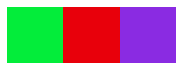

In [275]:
sns.palplot(l_5_colors_hex)

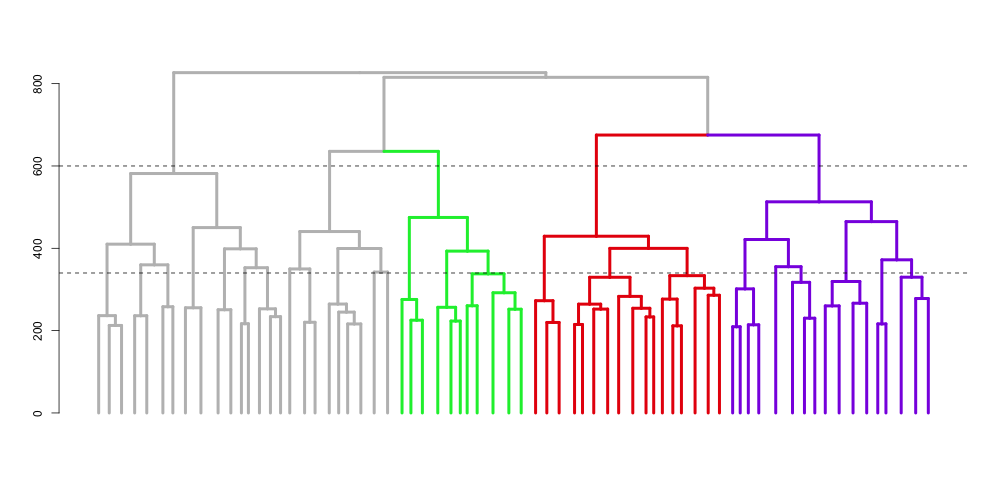

In [362]:
%%R -w 1000 -h 500
# png(filename='../reports/lfc/figures/components/full_k70_dendrogram.png', 1000, 500)

k_70_dend <- cut(dend, h=209)$upper
k_70_dend  %>% 
set("labels", c(1:71)) %>%
set("branches_col", c('grey')) %>%
set("branches_k_color", value = c("grey", "grey", l_5_colors_hex), k = 5) %>% 
# set("branches_k_color", value = c(1, 2, 3), k = 33) %>% 
# prune(dendrogram_prune) %>% 
set("branches_lwd", 4) %>%
hang.dendrogram(-1) %>%
# set("leaves_col", dendrogram_colors_70) %>%
# set("leaves_pch", 19) %>%
# set("leaves_cex", 1.1) %>%
set("labels", c("")) %>%
plot()
# as.ggdend() %>%
# ggplot()
abline(h = 340, lty = 2)
abline(h = 600, lty = 2)
# dev.off()

## Visualize solutions

In [14]:
%gui qt
# from surfer import Brain, project_volume_data
os.environ['SUBJECTS_DIR'] = '/Applications/freesurfer/subjects/'
os.environ['FREESURFER_HOME'] = '/Applications/freesurfer/'
from IPython.display import Image

In [10]:
l_5_masked = base.img_plot.mask_nifti(l_5, LFC_mask_1p)
l_33_masked = base.img_plot.mask_nifti(l_33, LFC_mask_1p)
l_70_masked = base.img_plot.mask_nifti(l_70, LFC_mask_1p)

AttributeError: 'module' object has no attribute 'img_plot'

In [11]:
l_5to33 = map_clusters(l_5, l_33)
l_33to70 = map_clusters(l_33, l_70)
l_5to70 = map_clusters(l_5, l_70)

In [12]:
l_5to70

{1: array([], dtype=int64),
 2: array([1, 2]),
 3: array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
 4: array([12, 13, 14])}

In [13]:
l_5_colors = sns.color_palette('bright', 4)[1:]

In [14]:
sns.palplot(l_5_colors)

In [15]:
# l_70_colors = [(0.8, 0.7254901960784313, 0.4549019607843137),
l_70_colors = [(0.2160246080043269, 0.49487120380588606, 0.7198769869757634),
(0.9585082685246187, 0.5084660039228551, 0.7449288887136123),
 (0.8941176533699036, 0.10196078568696976, 0.10980392247438431),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.8, 0.4745098039215686, 0.6549019607843137),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.0, 0.6196078431372549, 0.45098039215686275),
 (0.9411764705882353, 0.8941176470588236, 0.25882352941176473),
 (0.6008304736193488, 0.30814303335021526, 0.6316955229815315),
(0.30426760128900115, 0.6832910605505401, 0.29293349969620797),
(0.0, 0.8431372549019608, 1.0),
               (0.011764705882352941, 0.9294117647058824, 0.22745098039215686),
 (0.0, 0.24705882352941178, 1.0),
 (0.6584544609574711, 0.34122261685483596, 0.1707958535236471)]

mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpy07dDd.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sYcedol.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpy07dDd.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sYcedol.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpy07dDd.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sPMySio.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpy07dDd.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sPMySio.mgz
/Users/aleph4/anaconda/lib/python2.7/site-packages/surfer/viz.py:2446: UserWarning: Data min is greater than threshold.
  warn("Data min is greater than threshold.")
/Users/aleph4/anaconda/lib/python2.7/site-packages/mayavi/tools/camera.py:288: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if focalpoint is not None and not focalpoint == 'auto':


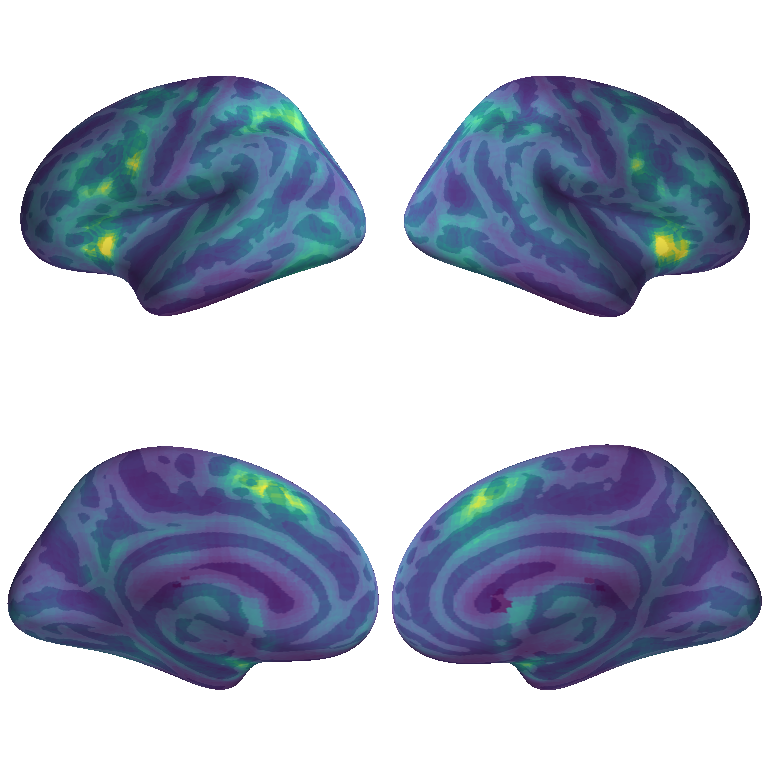

In [33]:
mean_activation = dataset.image_table.data.mean(axis=1)
activation_3d = nib.Nifti1Image(dataset.masker.unmask(mean_activation).squeeze(), affine=LFC_mask.get_affine())

brain = Brain('fsaverage', 'split', 'inflated', cortex='bone', size=(780, 800), background='white', views=['lat', 'med'])
base.img_plot.display_bilateral(brain, activation_3d, colormap=plt.get_cmap('viridis').colors, max=.075, thresh=0, min=0, discrete=False)
out = '../reports/dissertation/figures/base_rate.png'
brain.save_image(out)
Image(out)

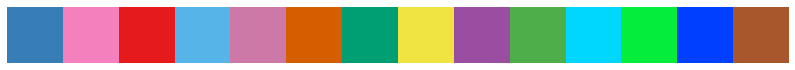

In [197]:
sns.palplot(l_70_colors[1:])

In [221]:
len(l_70_colors[1:])

14

In [222]:
len(range(1, 15))

14

In [270]:
brain = Brain('fsaverage', 'split', 'inflated', cortex='bone', size=(820, 400), background='white', views=['lat'])
_ = base.img_plot.display_bilateral(brain, l_70, colormap=l_70_colors[1:], level_mask=None, spatial_mask=None)
brain.show_view({'azimuth': 22, 'elevation': 86}, distance=430, roll=-90, col=1)
brain.show_view({'azimuth': 162, 'elevation': 86}, distance=430, roll=90, col=0)
out = '../reports/lfc/figures/all_regions.png'
brain.save_image(out)
Image(out)

mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp5zjoba.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sQSABiE.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp5zjoba.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sQSABiE.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp5zjoba.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s9mWtRt.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp5zjoba.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s9mWtRt.mgz


IndexError: list index out of range

mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpCmnXOh.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s8dO13Q.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpCmnXOh.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s8dO13Q.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpCmnXOh.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s87SgRQ.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpCmnXOh.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s87SgRQ.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpFMK6uE.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sgPLfnj.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpFMK6uE.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sgPLfnj.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpFMK6uE.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sK6HPZA.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpFMK6uE.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sK6HPZA.mgz


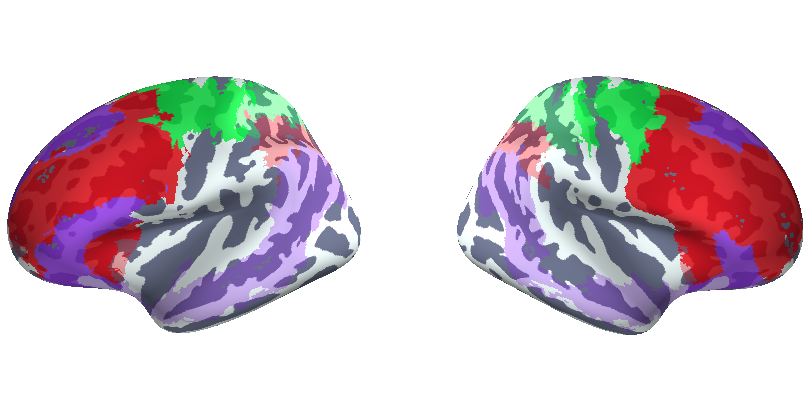

In [274]:
brain = Brain('fsaverage', 'split', 'inflated', cortex='bone', size=(820, 400), background='white', views=['lat'])
_ = base.img_plot.display_bilateral(brain, l_5, colormap=sns.color_palette('bright', 4), level_mask=[2, 3, 4], spatial_mask=LFC_mask_1p)
brain.show_view({'azimuth': 22, 'elevation': 86}, distance=430, roll=-90, col=1)
brain.show_view({'azimuth': 162, 'elevation': 86}, distance=430, roll=90, col=0)
out = '../reports/lfc/figures/all_networks.png'
brain.save_image(out)
Image(out)

mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp5xW38m.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sIf1mN2.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp5xW38m.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sIf1mN2.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp5xW38m.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2spv2T4W.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp5xW38m.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2spv2T4W.mgz


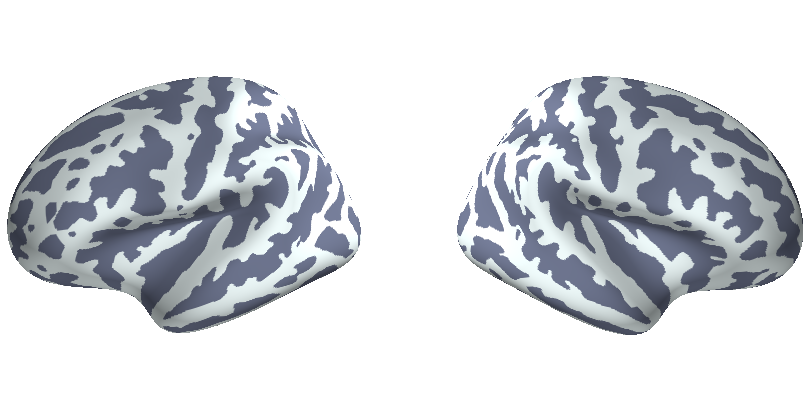

In [563]:
brain = Brain('fsaverage', 'split', 'inflated', cortex='bone', size=(820, 400), background='white', views=['lat'])
_ = base.img_plot.display_bilateral(brain, l_33, colormap=l_33_colors, level_mask=l_5to33[1])
brain.show_view({'azimuth': 22, 'elevation': 86}, distance=430, roll=-90, col=1)
brain.show_view({'azimuth': 162, 'elevation': 86}, distance=430, roll=90, col=0)
out = '../reports/dissertation/figures/va_33_regions.png'
brain.save_image(out)
Image(out)

mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpoGR7Tp.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s1vEfmS.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpoGR7Tp.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s1vEfmS.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpoGR7Tp.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sNkB1b7.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpoGR7Tp.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sNkB1b7.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp8jkfG_.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s0QhSuN.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp8jkfG_.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s0QhSuN.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp8jkfG_.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s9yor1H.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp8jkfG_.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s9yor1H.mgz


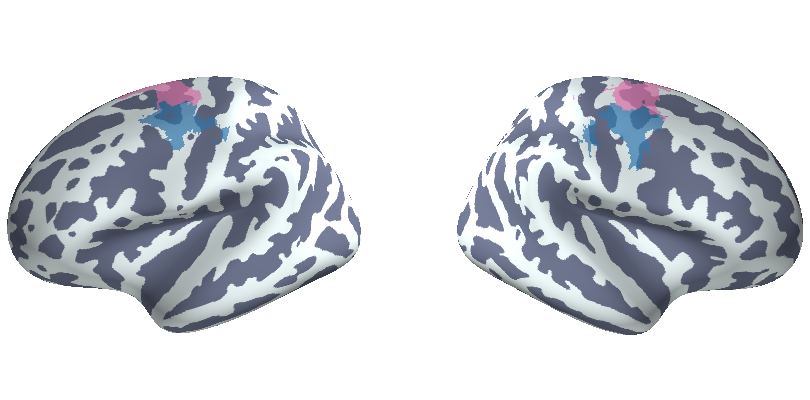

In [207]:
brain = Brain('fsaverage', 'split', 'inflated', cortex='bone', size=(820, 400), background='white', views=['lat'])
_ = base.img_plot.display_bilateral(brain, l_33, colormap=l_33_colors, level_mask=l_5to33[2], spatial_mask=LFC_mask_1p)
brain.show_view({'azimuth': 22, 'elevation': 86}, distance=430, roll=-90, col=1)
brain.show_view({'azimuth': 162, 'elevation': 86}, distance=430, roll=90, col=0)
# out = '../reports/dissertation/figures/motor_33_regions.png'
brain.save_image(out)
Image(out)

mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp_oTaip.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2svxsF6j.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp_oTaip.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2svxsF6j.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp_oTaip.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sLssXtS.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp_oTaip.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sLssXtS.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpb8iLrq.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sEokgoG.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpb8iLrq.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sEokgoG.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpb8iLrq.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sXM4ozC.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpb8iLrq.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sXM4ozC.mgz
/Users/aleph4/anaconda/lib/python2.7/site-packages/mayavi/tools/camera.py:288: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if focalpoint is not None and not focalpoint == 'auto':


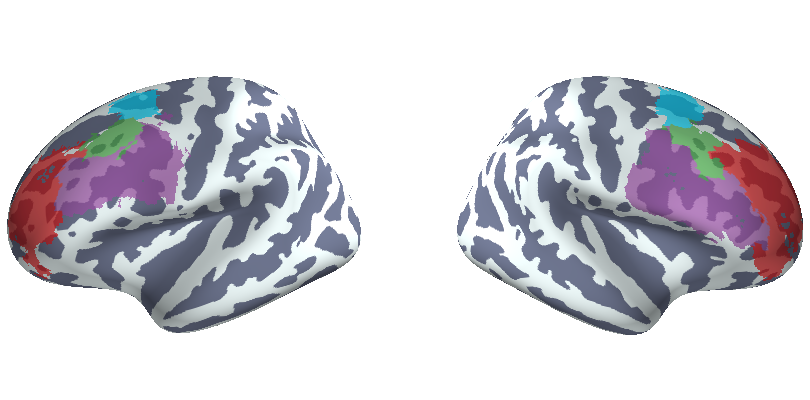

In [203]:
brain = Brain('fsaverage', 'split', 'inflated', cortex='bone', size=(820, 400), background='white', views=['lat'])
_ = base.img_plot.display_bilateral(brain, l_33, colormap=l_33_colors, level_mask=l_5to33[3], spatial_mask=LFC_mask_1p)
brain.show_view({'azimuth': 22, 'elevation': 86}, distance=430, roll=-90, col=1)
brain.show_view({'azimuth': 162, 'elevation': 86}, distance=430, roll=90, col=0)
out = '../reports/dissertation/figures/fpn_33_regions.png'
brain.save_image(out)
Image(out)

### Motor network (k = 70)

### Motor and VA

mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp0M5tYt.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2spUMJG7.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp0M5tYt.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2spUMJG7.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp0M5tYt.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sMJ0f3q.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp0M5tYt.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sMJ0f3q.mgz


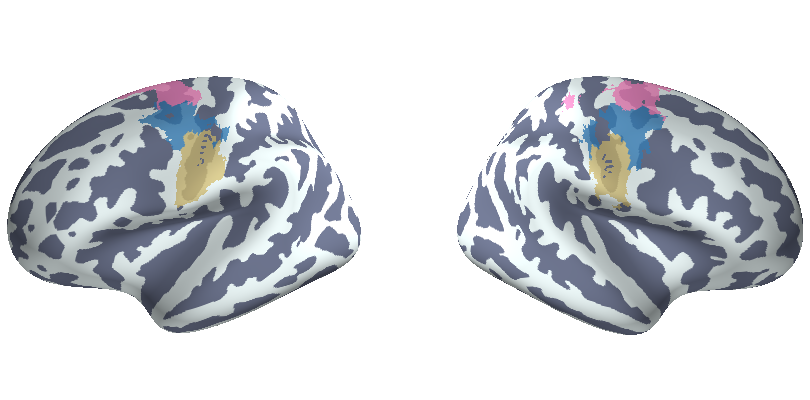

In [352]:
brain = Brain('fsaverage', 'split', 'inflated', cortex='bone', size=(820, 400), background='white', views=['lat'])
_ = base.img_plot.display_bilateral(brain, l_70, colormap=l_70_colors, level_mask=[1, 2, 3])
brain.show_view({'azimuth': 22, 'elevation': 86}, distance=430, roll=-90, col=1)
brain.show_view({'azimuth': 162, 'elevation': 86}, distance=430, roll=90, col=0)
out = '../reports/dissertation/figures/motor_va_regions.png'
brain.save_image(out)
Image(out)

mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpvN6azP.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sggjMFh.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpvN6azP.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sggjMFh.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpvN6azP.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2spG36mM.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpvN6azP.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2spG36mM.mgz


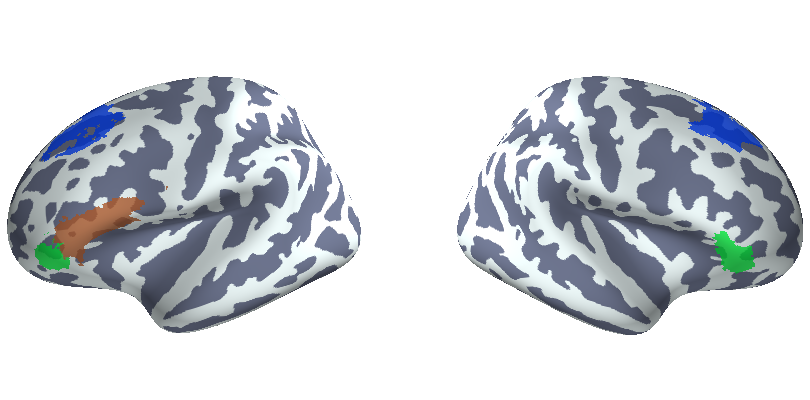

In [172]:
brain = Brain('fsaverage', 'split', 'inflated', cortex='bone', size=(820, 400), background='white', views=['lat'])
_ = base.img_plot.display_bilateral(brain, l_70, colormap=l_70_colors, level_mask=l_5to70[4])
brain.show_view({'azimuth': 22, 'elevation': 86}, distance=430, roll=-90, col=1)
brain.show_view({'azimuth': 162, 'elevation': 86}, distance=430, roll=90, col=0)
out = '../reports/dissertation/figures/k_70_default_regions.png'
brain.save_image(out)
Image(out)

In [ ]:
brain = Brain('fsaverage', 'split', 'inflated', cortex='bone', size=(820, 400), background='white', views=['lat'])
_ = base.img_plot.display_bilateral(brain, l_70, colormap=l_70_colors, level_mask=[11, 12])
brain.show_view({'azimuth': 22, 'elevation': 86}, distance=430, roll=-90, col=1)
brain.show_view({'azimuth': 162, 'elevation': 86}, distance=430, roll=90, col=0)
out = '../reports/dissertation/figures/k_70_fpn_pLPFC.png'
brain.save_image(out)
Image(out)

mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpOqB99b.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sYoXdRU.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpOqB99b.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sYoXdRU.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpOqB99b.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s62DdE7.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpOqB99b.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-max 0 1 0.1 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s62DdE7.mgz
Exception KeyboardInterrupt in <module 'threading' from '/Users/aleph4/anaconda/lib/python2.7/threading.pyc'> ignored


In [366]:
sns.color_palette('bright', 10)[4]

(1.0, 0.7686274509803922, 0.0)

# Coactivation

In [229]:
from base.coactivation import coactivation_contrast
%load_ext autoreload
%autoreload 2
from base.img_plot import make_thresholded_slices, plot_subset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### 70 region level

#### Posterior LFC

In [236]:
r = 3
regions = np.arange(1, 15)
colormap = list(np.array(l_70_colors)[regions - 1])

In [237]:
l_70_c = coactivation_contrast(dataset, l_70_masked, regions=regions, target_thresh=0.01, other_thresh=0.01, q=0.01, contrast='joint')

In [555]:
brain = Brain('fsaverage', 'split', 'inflated', cortex='bone', size=(780, 800), background='white', views=['lat', 'med'])
base.img_plot.display_coactivation(brain, 
                                   l_70_c[0:1],
                                   colormap=colormap[0:1], alpha=0.7)
out = '../reports/lfc/figures/l_70_va.png'
brain.save_image(out)
Image(out)

mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpLD5rRh.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sPPB1Vr.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpLD5rRh.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sPPB1Vr.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpLD5rRh.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sv_oHe9.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpLD5rRh.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sv_oHe9.mgz


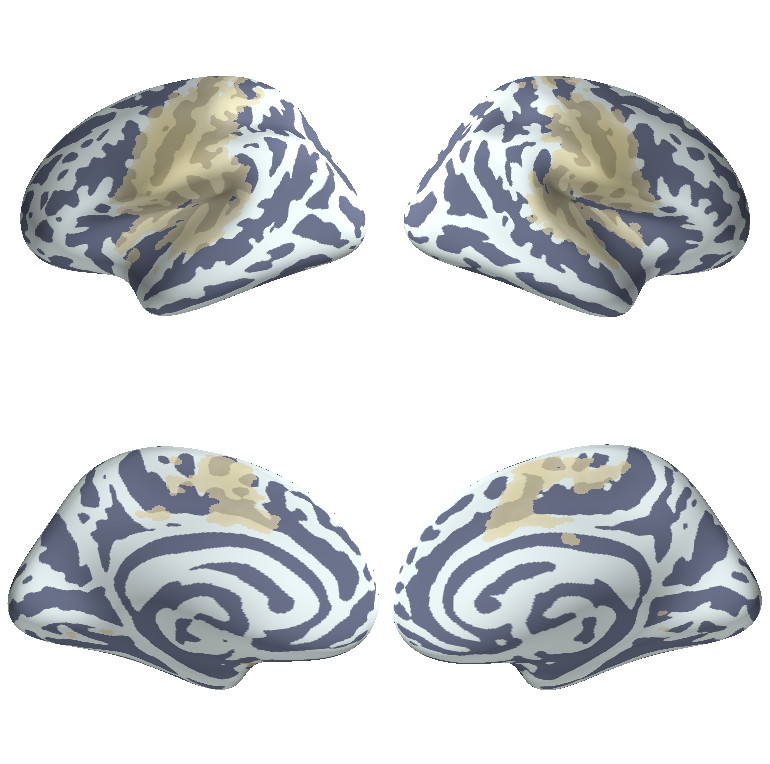

mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmplwKmff.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sCcpk66.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmplwKmff.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sCcpk66.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmplwKmff.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2syMQB5m.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmplwKmff.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2syMQB5m.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpXb5Kxh.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s8dc6GC.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpXb5Kxh.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s8dc6GC.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpXb5Kxh.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sMJVsf7.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpXb5Kxh.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sMJVsf7.mgz


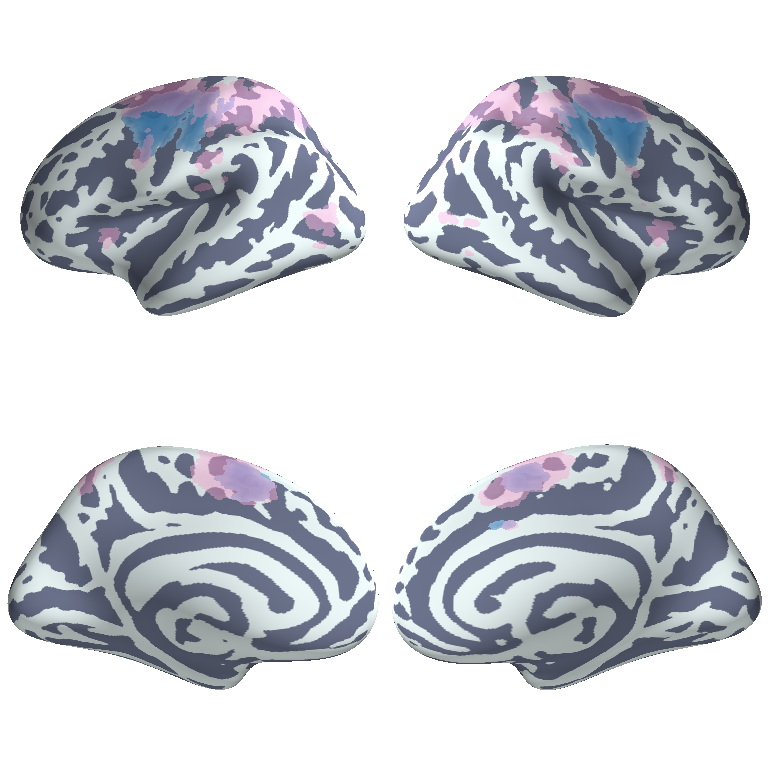

In [369]:
brain = Brain('fsaverage', 'split', 'inflated', cortex='bone', size=(780, 800), background='white', views=['lat', 'med'])
base.img_plot.display_coactivation(brain, 
                                   l_70_c[0:2],
                                   colormap=colormap[0:2], alpha=0.9, reduce_alpha_step=0.42)
out = '../reports/lfc/figures/l_70_motor.png'
brain.save_image(out)
Image(out)

In [240]:
brain = Brain('fsaverage', 'split', 'inflated', cortex='bone', size=(780, 800), background='white', views=['lat', 'med'])
base.img_plot.display_coactivation(brain, 
                                   l_70_c[2:5],
                                   colormap=colormap[2:5], alpha=0.65)

mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpN2XO1f.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sfRvvjC.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpN2XO1f.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sfRvvjC.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpN2XO1f.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sPBCOUM.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpN2XO1f.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sPBCOUM.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpIsRLLJ.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sJyPAwr.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpIsRLLJ.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sJyPAwr.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpIsRLLJ.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2svkD546.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpIsRLLJ.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2svkD546.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpF5BduX.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sdwMosW.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpF5BduX.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sdwMosW.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpF5BduX.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sSJCuXP.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpF5BduX.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sSJCuXP.mgz


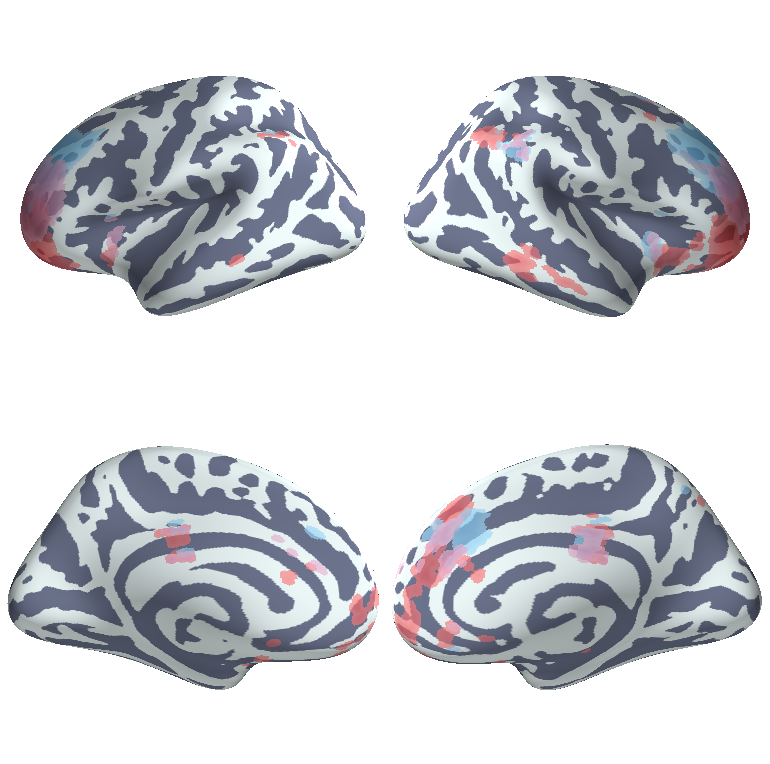

In [241]:
out = '../reports/dissertation/figures/l_70_rostral_FPN.png'
brain.save_image(out)
Image(out)

In [242]:
brain = Brain('fsaverage', 'split', 'inflated', cortex='bone', size=(780, 800), background='white', views=['lat', 'med'])
base.img_plot.display_coactivation(brain, 
                                   l_70_c[5:9],
                                   colormap=colormap[5:9], alpha=0.7, min=0.01, thresh=0.001)

mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpW31s1V.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sLjONBX.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpW31s1V.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sLjONBX.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpW31s1V.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s2u6foI.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpW31s1V.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s2u6foI.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmppP6eXx.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sr6j5Xn.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmppP6eXx.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sr6j5Xn.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmppP6eXx.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s6tHoKK.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmppP6eXx.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s6tHoKK.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp2ra0cF.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sAvayPo.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp2ra0cF.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sAvayPo.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp2ra0cF.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sGcF0Nz.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp2ra0cF.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sGcF0Nz.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp3SnU3N.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2snr1nzC.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp3SnU3N.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2snr1nzC.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp3SnU3N.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sNCyO8A.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp3SnU3N.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sNCyO8A.mgz


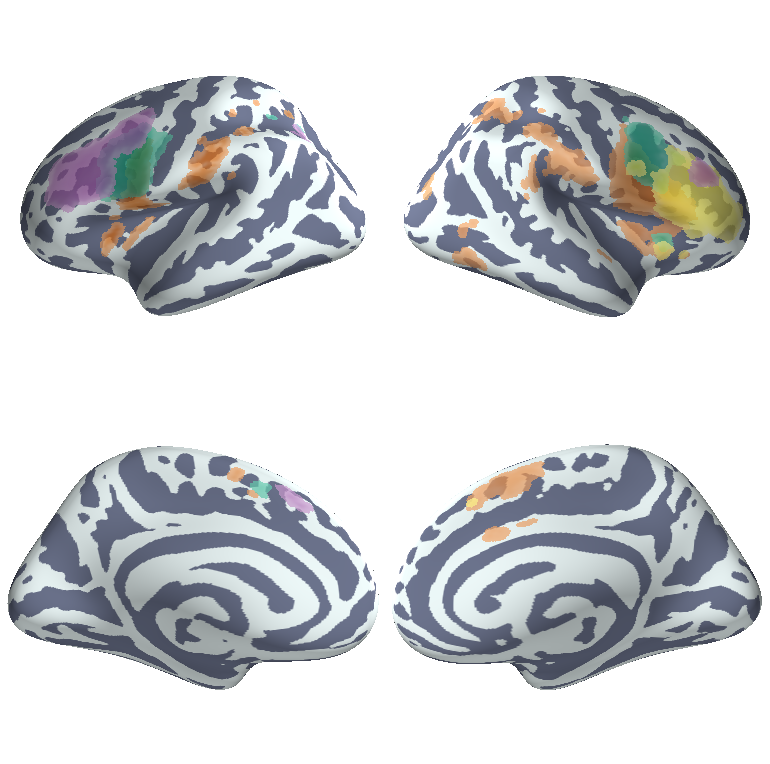

In [243]:
out = '../reports/dissertation/figures/l_70_mid_FPN.png'
brain.save_image(out)
Image(out)

In [244]:
brain = Brain('fsaverage', 'split', 'inflated', cortex='bone', size=(780, 800), background='white', views=['lat', 'med'])
base.img_plot.display_coactivation(brain, 
                                   l_70_c[9:11],
                                   colormap=colormap[9:11], alpha=0.7)

mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpXF6OLL.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2ssOXasQ.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpXF6OLL.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2ssOXasQ.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpXF6OLL.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sF2Wiyd.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpXF6OLL.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sF2Wiyd.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmppuKk7U.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s_3pT3R.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmppuKk7U.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s_3pT3R.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmppuKk7U.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2stFs4sO.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmppuKk7U.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2stFs4sO.mgz


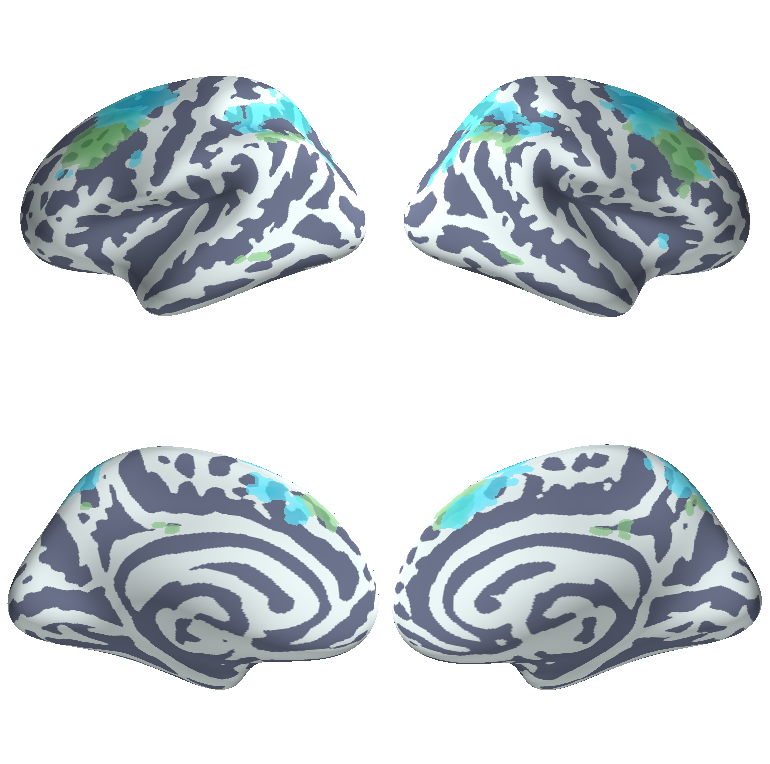

In [245]:
out = '../reports/dissertation/figures/l_70_caudal_FPN.png'
brain.save_image(out)
Image(out)

In [246]:
brain = Brain('fsaverage', 'split', 'inflated', cortex='bone', size=(780, 800), background='white', views=['lat', 'med'])
base.img_plot.display_coactivation(brain, 
                                   l_70_c[11:],
                                   colormap=colormap[11:], alpha=0.7)

mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp3ferPT.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s91xPPO.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp3ferPT.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2s91xPPO.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp3ferPT.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2szecVUm.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmp3ferPT.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2szecVUm.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpsiYfkw.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sCtxJIB.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpsiYfkw.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sCtxJIB.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpsiYfkw.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sQdmCGK.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpsiYfkw.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2sQdmCGK.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpRx10Xx.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2saRD95X.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpRx10Xx.nii.gz --hemi lh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2saRD95X.mgz


mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpRx10Xx.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2scgwaiW.mgz


INFO:surfer:mri_vol2surf --mov /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/tmpRx10Xx.nii.gz --hemi rh --surf white --regheader fsaverage --projfrac-avg 0 1 0.1 --surf-fwhm 2 --o /var/folders/k7/sjgnyj6j5z17gr14p3cnp0fc0000gn/T/pysurfer-v2scgwaiW.mgz


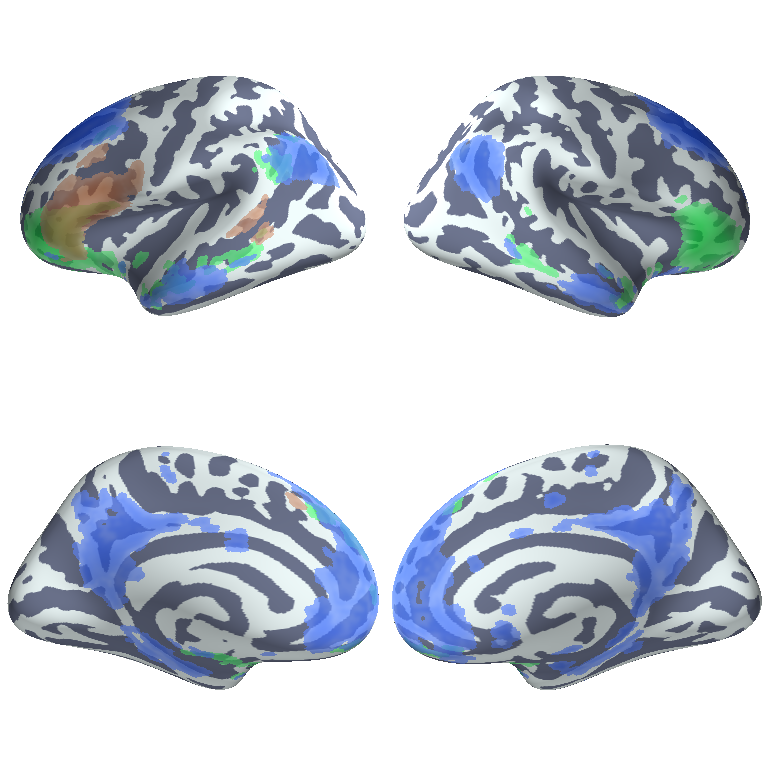

In [247]:
out = '../reports/dissertation/figures/l_70_default.png'
brain.save_image(out)
Image(out)

## Functional profiles

In [16]:
%aimport base.plotting
ml.style.use('seaborn-dark')
def calculate_odds_ratio(thetas, f=0.1):
    t = thetas + f
    return np.log((t[:, 1, :] / t[:, 0, :]))

In [17]:
clf5 = OnevsallClassifier.load('../results/classification/LFC_scaled_masked_5_GNB_t0.05_all_topics_60/classifier_nd.pkl')
clf33 = OnevsallClassifier.load('../results/classification/LFC_scaled_masked_33_GNB_t0.05_all_topics_60/classifier_nd.pkl')
clf70 = OnevsallClassifier.load('../results/classification/LFC_scaled_masked_70_GNB_t0.05_all_topics_60/classifier_nd.pkl')

In [18]:
## Topic nicknames
nicknames = pd.read_csv('../data/0.6/topics/keys/v4-topics-60.txt', delimiter='\t')
nicknames['topic_name'] = nicknames.apply(lambda row: '_'.join([str(row.topic_number)] + row.top_words.split(' ')[0:3]), axis=1)
nicknames = nicknames.sort_values('topic_name')

In [19]:
average_all_topics = ['pain', 'reward', 'memory', 'emotion', 'mentalizing', 'inhibition', 'novelty', 'switching', 'conflict', 'WM',
                      'semantics', 'speech', 'attention', 'action', 'motor', 'gaze']

In [20]:
posterior_topics, _ =  base.plotting.plot_clf_polar_v6(clf70, key='topic', label_size=28, feature_names=nicknames.nickname, 
                                     reorder=False,  labels=posterior_topics, n_top=12, cmap=l_70_colors, 
                                                 max_val=1.5, mask=[2, 3],)
# plt.savefig('../reports/dissertation/figures/function_70_motor_va.png')

NameError: name 'posterior_topics' is not defined

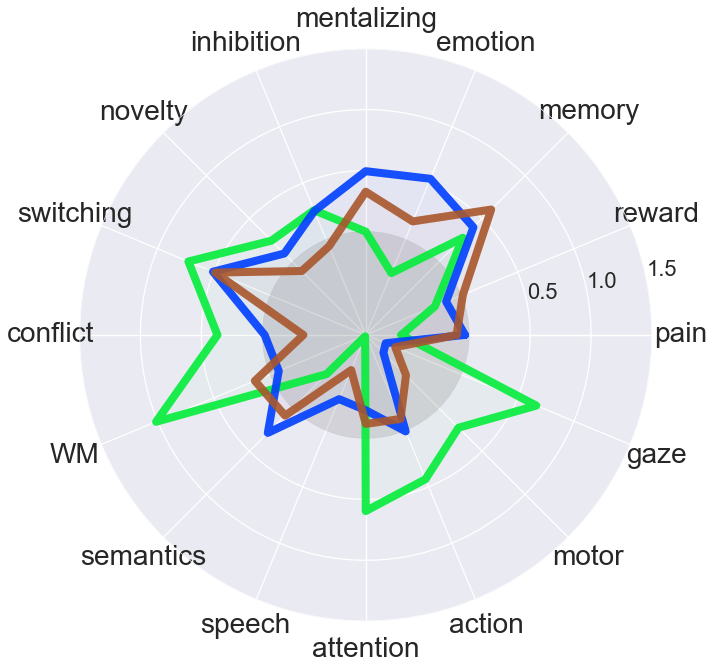

In [24]:
_, data_default =  base.plotting.plot_clf_polar_v6(clf70, key='topic', label_size=28, feature_names=nicknames.nickname, 
                                     reorder=False, method='weighted', labels=average_all_topics, n_top=12,  selection='std', cmap=l_70_colors, max_val=1.5, mask=l_5to70[4])
# plt.savefig('../reports/dissertation/figures/function_70_default.png')

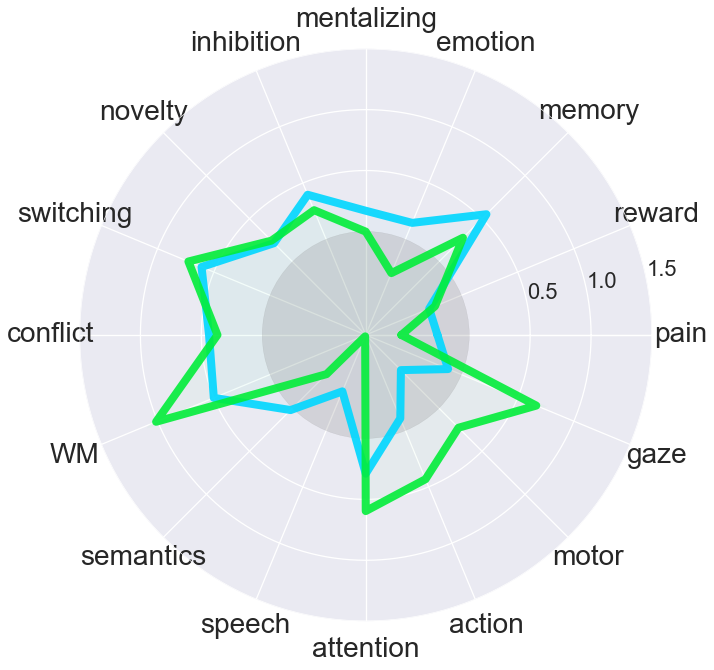

In [25]:
_, data_caudal =  base.plotting.plot_clf_polar_v6(clf70, key='topic', label_size=28, feature_names=nicknames.nickname, 
                                     reorder=False, labels=average_all_topics, cmap=l_70_colors, max_val=1.5, mask=[11, 12],
                                           method='weighted')
# plt.savefig('../reports/dissertation/figures/function_70_caudal.png')

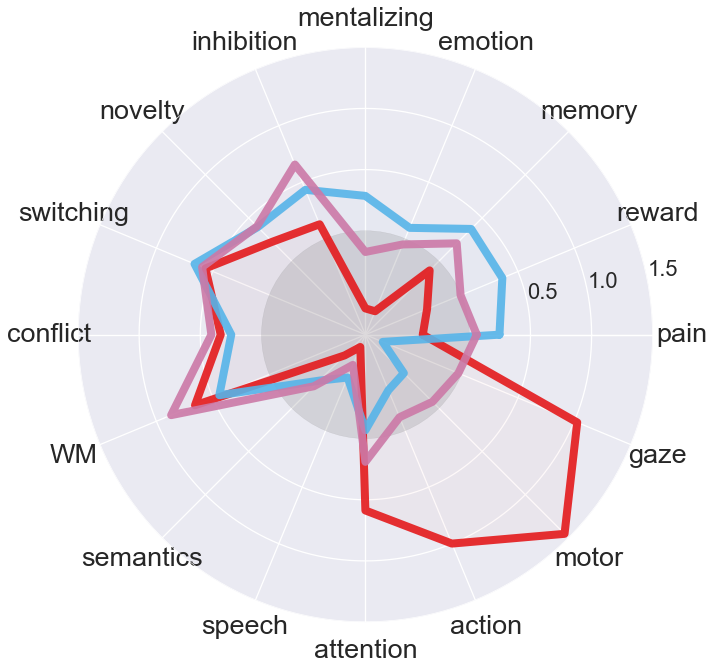

In [26]:
_, data_fp =  base.plotting.plot_clf_polar_v6(clf70, key='topic', label_size=27, feature_names=nicknames.nickname, 
                                     reorder=False, labels=average_all_topics, cmap=l_70_colors,
                                     max_val=1.5, mask=l_33to70[4], method='complete')
# plt.savefig('../reports/dissertation/figures/function_70_fp.png')

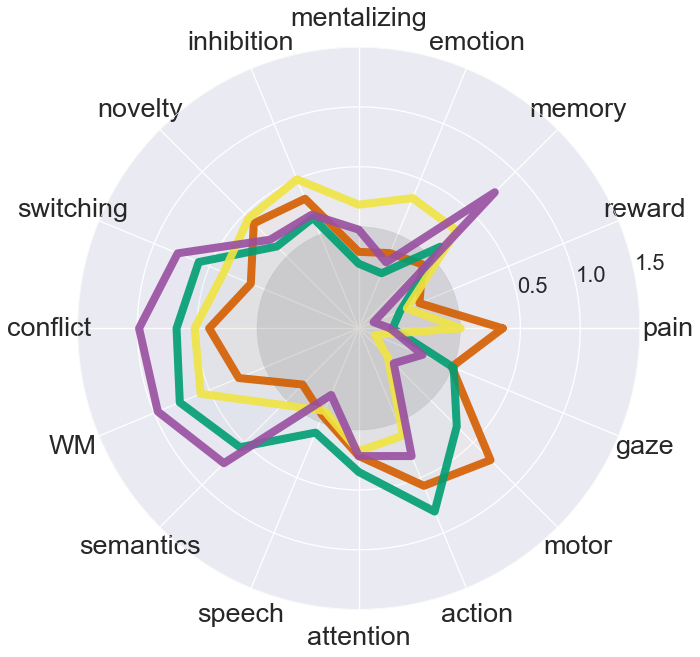

In [155]:
_, data_mid =  base.plotting.plot_clf_polar_v6(clf70, key='topic', label_size=27, feature_names=nicknames.nickname, 
                                     reorder=False, labels=average_all_topics, n_top=4,  selection='top', cmap=l_70_colors,
                                     max_val=1.5, mask=l_33to70[5])
plt.savefig('../reports/dissertation/figures/function_70_mid.png')

In [530]:
data = pd.concat([data_fp, data_caudal, data_mid], axis=1)
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, leaves_list
dists = pdist(data, metric='correlation')
pairs = linkage(dists, method='weighted')
pairs[pairs < 0] = 0
order = leaves_list(pairs)
data = data.iloc[order,:]
average_all_topics_fp = list(data.index)

## Permutation test

In [35]:
names_5 = ['Motor', 'FPN', 'Default']
names_70 = ['PMv', 'PMd', '10v', '9/46dr', '10d', '44 [R]', 'IFJ', 'IFG [R]', '9/46v', '9/46dc', '6/8', '47/12', '9', '45 [L]']

In [36]:
names_70to5 = {'PMv': 'Motor', 'PMd': 'Motor', '10v': 'FPN', '9/46dr': 'FPN', '10d': 'FPN', '44 [R]': 'FPN', 'IFJ': 'FPN',
               'IFG [R]': 'FPN', '9/46v': 'FPN', '9/46dc': 'FPN', '6/8': 'FPN', '47/12': 'Default', '9': 'Default', '45 [L]': 'Default'}

In [249]:
%aimport base.permutation
import scipy.stats as st
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [45]:
clf70.dataset = dataset
clf70.load_data(None, None)

IOError: [Errno 2] No such file or directory: '../results/clustering/hierarchical/fastward_v6_scaled_LFC/l_70_masked.nii.gz'

In [ ]:
select_ps.pivot(index='ROI', columns='nickname', values='reject_01').ix[['47/12', '45_L', '9'], average_all_topics]

## Bootstrapped CIs

In [27]:
import matplotlib.colors as colors

In [42]:
# clf5_lor_ci = base.permutation.bootstrap_log_odds(clf5, 1000, feature_names=list(nicknames.nickname), 
#                                                   region_names = ['VA', 'Motor', 'FPN', 'Default'], n_jobs=7)
# test_plot = clf5_lor_ci[clf5_lor_ci.topic_name.isin(all_topics)]
# colors_hex = list(reversed([colors.rgb2hex(c) for c in l_5_colors]))
# %Rpush test_plot
# %Rpush colors_hex

In [28]:
from base import permutation

In [33]:
%%R -w 400 -h 1200 
library(ggplot2)
ggplot(test_plot, aes(mean, region, color=factor(region), group=factor(region))) + geom_point(size=2.5) + 
geom_errorbarh(aes(xmin=low_ci, xmax=hi_ci), height=.2, size=.75) + geom_vline(xintercept = 0, alpha=.5) + facet_grid(topic_name~.) +
theme_bw(base_size = 18) +  theme(legend.position="none") + labs(x = 'Strength of association (LOR)', y="")+
scale_color_manual(values = colors_hex)


Error in ggplot(test_plot, aes(mean, region, color = factor(region), group = factor(region))) : 
  object 'test_plot' not found


/Users/alejandro/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: Error in ggplot(test_plot, aes(mean, region, color = factor(region), group = factor(region))) : 
  object 'test_plot' not found

  warnings.warn(x, RRuntimeWarning)


In [43]:
clf70_lor_ci = permutation.bootstrap_log_odds(clf70, 1000, feature_names=list(nicknames.nickname), 
                                                  region_names =names_70, n_jobs=7)
test_plot = clf70_lor_ci[(clf70_lor_ci.topic_name.isin(average_all_topics))]
colors_hex = [colors.rgb2hex(c) for c in l_70_colors]
colors_hex, _ = zip(*sorted(zip(colors_hex, names_70), key=lambda tup: tup[1]))
colors_hex = list(colors_hex)
names = list(reversed(names_70))
%Rpush test_plot
%Rpush colors_hex
%Rpush names

ZeroDivisionError: float division by zero

In [44]:
%debug

> /Users/alejandro/Dropbox/projects/ns_classify/code/base/tools.py(51)next()
     49 
     50     def next(self):
---> 51         if not self.last_int == int((self.current) / self.total * 100):
     52             self.update_progress(int((self.current) / self.total * 100))
     53             self.last_int = int((self.current) / self.total * 100)

ipdb> self.total
0
ipdb> u
> /Users/alejandro/Dropbox/projects/ns_classify/code/base/tools.py(40)__init__()
     38         self.last_int = 0
     39         if start:
---> 40             self.next()
     41 
     42     def update_progress(self, progress):

ipdb> u
> /Users/alejandro/Dropbox/projects/ns_classify/code/base/permutation.py(65)bootstrap_log_odds()
     63     from statistics import percentile
     64 
---> 65     pb = ProgressBar(len(clf.data), start=True)
     66 
     67     if feature_names is None:

ipdb> exit


In [ ]:
average_all_topics.sort()

In [ ]:
average_all_topics

In [ ]:
s1 = ['WM',
 'action',
 'attention',
 'conflict',
 'emotion',
 'gaze',
 'inhibition',
 'memory']

s2 = ['mentalizing',
 'motor',
 'novelty',
 'pain',
 'reward',
 'semantics',
 'speech',
 'switching']

%Rpush s2
%Rpush s1

In [ ]:
%%R -w 450 -h 1200 
library(ggplot2)
ggplot(subset(test_plot, topic_name %in% s1), aes(mean, region, color=factor(region))) + geom_point(size=2.5) + 
geom_errorbarh(aes(xmin=low_ci, xmax=hi_ci), height=.2, size=.85) + geom_vline(xintercept = 0, alpha=.5) + facet_grid(topic_name~.) +
theme_bw(base_size = 17) +  theme(legend.position="none") + labs(x = 'Strength of association (LOR)', y="") +
scale_color_manual(values = colors_hex) + scale_y_discrete(limits=names)

In [ ]:
%%R -w 450 -h 1200 
library(ggplot2)
ggplot(subset(test_plot, topic_name %in% s2), aes(mean, region, color=factor(region))) + geom_point(size=2.5) + 
geom_errorbarh(aes(xmin=low_ci, xmax=hi_ci), height=.2, size=.85) + geom_vline(xintercept = 0, alpha=.5) + facet_grid(topic_name~.) +
theme_bw(base_size = 17) +  theme(legend.position="none") + labs(x = 'Strength of association (LOR)', y="") +
scale_color_manual(values = colors_hex) + scale_y_discrete(limits=names)

### Coactivation distance

In [278]:
from neurosynth.analysis.reduce import average_within_regions

In [279]:
l_70_activation = average_within_regions(dataset, l_70)

In [280]:
whole_brain_activation = joblib.load('../data/dv_v6_reference_pca.pkl')

In [281]:
l70_overallcoact_distances = pairwise_distances(l_70_activation, whole_brain_activation.data, metric='correlation')

In [282]:
l70_coact_distance = pd.DataFrame(pairwise_distances(l70_overallcoact_distances, metric='correlation'), index=names_70, columns=names_70)

In [283]:
mask= mask_diagonal(np.ma.masked_array(l70_coact_distance.values)).mask
l70_coact_distance = l70_coact_distance.replace(0, np.nan)

In [284]:
l70_coact_distance.values

array([[        nan,  0.47069577,  0.825764  ,  0.75654534,  0.76685632,
         0.59431847,  0.51726916,  0.74071601,  0.67156558,  0.69950505,
         0.6804245 ,  0.83951381,  0.83878426,  0.80555968],
       [ 0.47069577,         nan,  0.87697386,  0.71787423,  0.78260903,
         0.60861752,  0.61794909,  0.84026833,  0.75216749,  0.7949319 ,
         0.50477686,  0.90522297,  0.82607929,  0.93760262],
       [ 0.825764  ,  0.87697386,         nan,  0.58266992,  0.28099981,
         0.7554599 ,  0.78756561,  0.54644545,  0.65006492,  0.43944424,
         0.6443111 ,  0.41349449,  0.62272863,  0.77916923],
       [ 0.75654534,  0.71787423,  0.58266992,         nan,  0.2926745 ,
         0.70579844,  0.69331165,  0.6279446 ,  0.56136793,  0.45788479,
         0.6699796 ,  0.68929553,  0.50157774,  0.86369177],
       [ 0.76685632,  0.78260903,  0.28099981,  0.2926745 ,         nan,
         0.70505819,  0.71005961,  0.56313601,  0.56525707,  0.4551954 ,
         0.63532064,  0.60

In [286]:
l_5to70

{1: array([], dtype=int64),
 2: array([1, 2]),
 3: array([ 3,  4,  5,  6,  7,  8,  9, 10, 11]),
 4: array([12, 13, 14])}

### Functional distance

/Users/aleph4/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/aleph4/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


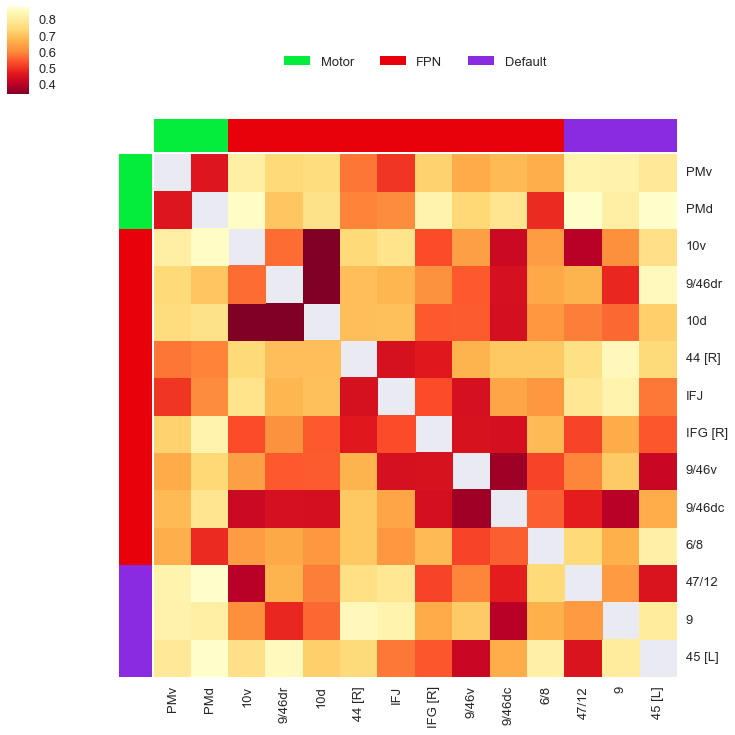

In [325]:
l_70_5colors = [l_5_colors[k-2] for k, v in l_5to70.items()[1:] for v1 in v ]
g = sns.clustermap(l70_coact_distance, cmap=plt.get_cmap('YlOrRd_r'), linewidths=0, 
           robust=True, col_cluster=False, row_cluster=False,
              col_colors=l_70_5colors, row_colors=l_70_5colors, xticklabels=True, yticklabels=True,
                figsize=(12, 12), mask=mask)
_ = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0, )
_ = g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, )

for i, label in enumerate(names_5):
    g.ax_col_dendrogram.bar(0, 0, color=l_5_colors[i],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)

In [395]:
l70_coact_stacked = l70_coact_distance.stack().reset_index()
l70_coact_stacked['level_0_net'] = l70_coact_stacked.level_0.map(names_70to5)
l70_coact_stacked['level_1_net'] = l70_coact_stacked.level_1.map(names_70to5)
l70_coact_stacked['within'] = l70_coact_stacked.level_0_net == l70_coact_stacked.level_1_net

In [401]:
l70_coact_stacked.groupby('within').mean()

0
within          
False   0.700076
True    0.580334

In [310]:
odds_ratio_distance = pd.DataFrame(pairwise_distances(clf70.odds_ratio[1:, :], metric='correlation'), index=names_70, columns=names_70)
odds_ratio_distance = odds_ratio_distance.replace(0, np.nan)
mask= mask_diagonal(np.ma.masked_array(odds_ratio_distance.values)).mask

In [402]:
l70_or_stacked = odds_ratio_distance.stack().reset_index()
l70_or_stacked['level_0_net'] = l70_or_stacked.level_0.map(names_70to5)
l70_or_stacked['level_1_net'] = l70_or_stacked.level_1.map(names_70to5)
l70_or_stacked['within'] = l70_or_stacked.level_0_net == l70_or_stacked.level_1_net

In [407]:
odds_ratio_distance

PMv       PMd       10v    9/46dr       10d    44 [R]       IFJ  \
PMv           NaN  0.207699  1.226330  0.914860  0.946649  0.255336  0.252445   
PMd      0.207699       NaN  1.049314  0.700775  0.814409  0.291657  0.426610   
10v      1.226330  1.049314       NaN  0.341308  0.300052  0.938706  1.061624   
9/46dr   0.914860  0.700775  0.341308       NaN  0.191144  0.837447  0.791789   
10d      0.946649  0.814409  0.300052  0.191144       NaN  0.779885  0.772486   
44 [R]   0.255336  0.291657  0.938706  0.837447  0.779885       NaN  0.293850   
IFJ      0.252445  0.426610  1.061624  0.791789  0.772486  0.293850       NaN   
IFG [R]  0.750503  0.882552  0.566412  0.565138  0.439761  0.498085  0.355410   
9/46v    0.575797  0.679141  0.776011  0.554866  0.517743  0.554295  0.155480   
9/46dc   0.868135  0.851672  0.504242  0.257243  0.251067  0.850082  0.549563   
6/8      0.427876  0.198094  0.729245  0.419554  0.520595  0.448223  0.384825   
47/12    0.998383  1.198497  0.457488  0.766450  0.525217  0.827417  0.708366   
9        1.279462  1.147562  0.423241  0.532618  0.432853  1.211170  1.077413   
45 [L]   0.749143  1.095709  0.903593  0.892841  0.712768  0.771258  0.316983   

          IFG [R]     9/46v    9/46dc       6/8     47/12         9    45 [L]  
PMv      0.750503  0.575797  0.868135  0.427876  0.998383  1.279462  0.749143  
PMd      0.882552  0.679141  0.851672  0.198094  1.198497  1.147562  1.095709  
10v      0.566412  0.776011  0.504242  0.729245  0.457488  0.423241  0.903593  
9/46dr   0.565138  0.554866  0.257243  0.419554  0.766450  0.532618  0.892841  
10d      0.439761  0.517743  0.251067  0.520595  0.525217  0.432853  0.712768  
44 [R]   0.498085  0.554295  0.850082  0.448223  0.827417  1.211170  0.771258  
IFJ      0.355410  0.155480  0.549563  0.384825  0.708366  1.077413  0.316983  
IFG [R]       NaN  0.255472  0.350917  0.588966  0.331769  0.752832  0.314571  
9/46v    0.255472       NaN  0.246257  0.392051  0.515502  0.770049  0.190283  
9/46dc   0.350917  0.246257       NaN  0.448015  0.524399  0.445946  0.450678  
6/8      0.588966  0.392051  0.448015       NaN  0.872129  0.849547  0.851738  
47/12    0.331769  0.515502  0.524399  0.872129       NaN  0.565352  0.315803  
9        0.752832  0.770049  0.445946  0.849547  0.565352       NaN  0.765935  
45 [L]   0.314571  0.190283  0.450678  0.851738  0.315803  0.765935       NaN

In [403]:
l70_or_stacked.groupby('within').mean()

0
within          
False   0.706079
True    0.508565

In [311]:
diff = pd.DataFrame((l70_coact_distance.values- odds_ratio_distance.values))

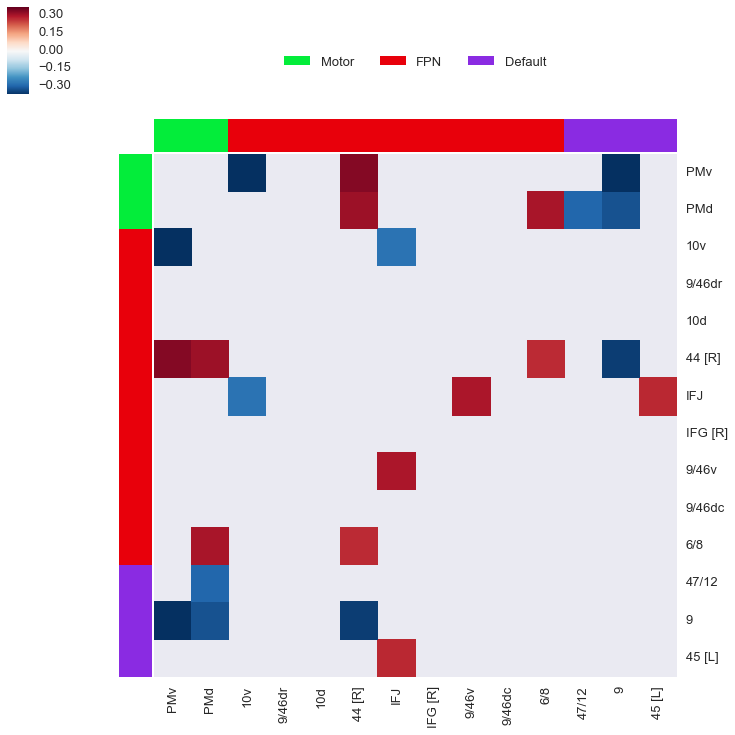

In [330]:
l_70_5colors = [l_5_colors[k-2] for k, v in l_5to70.items() for v1 in v]
g = sns.clustermap(diff,  linewidths=0, 
           robust=True, col_cluster=False, row_cluster=False,
              col_colors=l_70_5colors, row_colors=l_70_5colors, xticklabels=names_70, yticklabels=names_70,
                figsize=(12, 12), mask=np.abs(diff)<0.27)
_ = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0, )
_ = g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, )

for i, label in enumerate(names_5):
    g.ax_col_dendrogram.bar(0, 0, color=l_5_colors[i],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)

In [379]:
from scipy.stats import pearsonr
pearsonr(l70_coact_distance.values.flatten()[~np.isnan(l70_coact_distance.values.flatten())], odds_ratio_distance.values.flatten()[[~np.isnan(odds_ratio_distance.values.flatten())]])

1.4282499442987155e-54

/Users/aleph4/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:134: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if xticklabels == []:
/Users/aleph4/anaconda/lib/python2.7/site-packages/seaborn/matrix.py:142: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  if yticklabels == []:


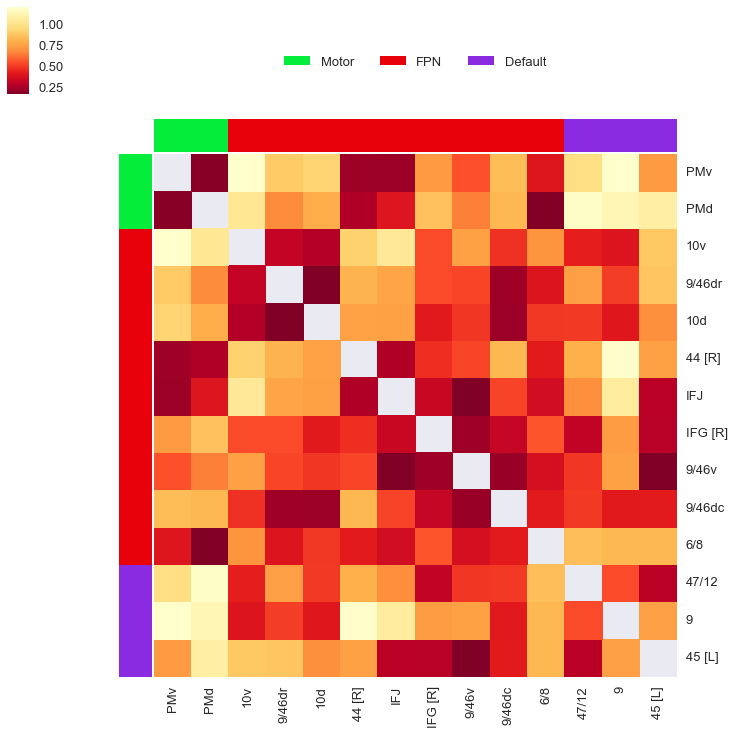

In [326]:
l_70_5colors = [l_5_colors[k-2] for k, v in l_5to70.items()[1:] for v1 in v]
g = sns.clustermap(odds_ratio_distance, cmap=plt.get_cmap('YlOrRd_r'), linewidths=0, 
           robust=True, col_cluster=False, row_cluster=False,
              col_colors=l_70_5colors, row_colors=l_70_5colors, xticklabels=True, yticklabels=True,
                figsize=(12, 12), mask=mask)
_ = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0, )
_ = g.ax_heatmap.set_xticklabels(g.ax_heatmap.get_xticklabels(), rotation=90, )

for i, label in enumerate(names_5):
    g.ax_col_dendrogram.bar(0, 0, color=l_5_colors[i],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)

In [ ]:
l_70_33colors = [l_33_colors[k-1] for k, v in l_33to70.items() for v1 in v]
g = sns.clustermap(odds_ratio_distance, cmap=plt.get_cmap('viridis'), linewidths=0, 
           robust=True, col_cluster=False, row_cluster=False,
              col_colors=l_70_33colors, row_colors=l_70_33colors, xticklabels=True, yticklabels=True,
                figsize=(15, 15), mask=mask)
_ = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0, )

for i, label in enumerate(names_33):
    g.ax_col_dendrogram.bar(0, 0, color=l_33_colors[i],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)

In [ ]:
g = sns.clustermap(odds_ratio_distance, cmap=plt.get_cmap('viridis'), linewidths=0, 
           robust=True, col_cluster=False, row_cluster=False,
              col_colors=l_70_colors, row_colors=l_70_colors, xticklabels=True, yticklabels=True,
                figsize=(15, 15), mask=mask)
_ = g.ax_heatmap.set_yticklabels(g.ax_heatmap.get_yticklabels(), rotation=0, )

for i, label in enumerate(names_70):
    g.ax_col_dendrogram.bar(0, 0, color=l_70_colors[i],
                            label=label, linewidth=0)
g.ax_col_dendrogram.legend(loc="center", ncol=6)

In [ ]:
sns.palplot(l_70_colors)

### Average cluster size

In [ ]:
np.bincount(np.round(
            nib.load(
            '../results/clustering/results/MFC/MF/kmeans_k9/cluster_labels.nii.gz').get_data().flatten()).astype('int64'))[1:].mean()

In [ ]:
np.bincount(np.round(
            nib.load(
            '../results/clustering/results/MFC/MF/kmeans_k3/cluster_labels.nii.gz').get_data().flatten()).astype('int64'))[1:].mean()

In [ ]:
(np.bincount(np.round(l_70.get_data().flatten()).astype('int64'))[1:]).mean()

In [ ]:
(np.bincount(np.round(l_33.get_data().flatten()).astype('int64'))[1:]).mean()

In [ ]:
(np.bincount(np.round(l_5.get_data().flatten()).astype('int64'))[1:]).mean()